<a href="https://colab.research.google.com/github/kmjohnson3/Intro-to-MRI/blob/master/NoteBooks/Spin_Echo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spin Echo
In this notebook, we will explore the solutions to the Bloch equations for a spin gradient echo sequence. Recall the spin echo has a timing diagram that looks like:

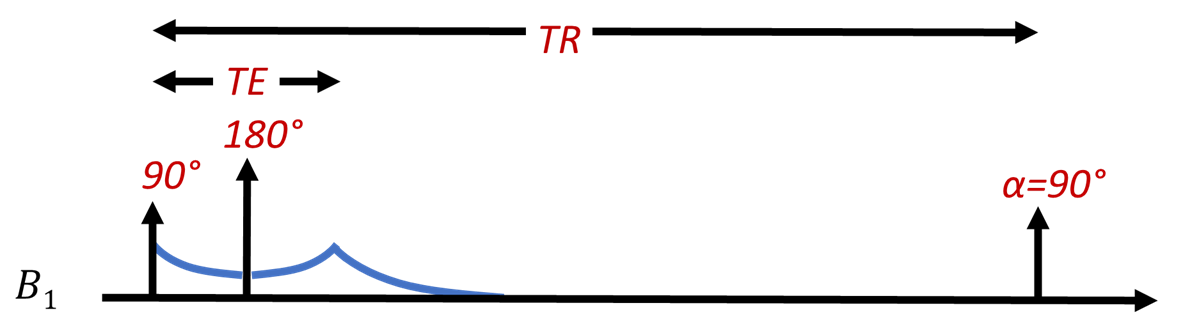

where $TR$ is the time between $90^{\circ}$ excitations and TE is the double the spacing between excitations.


In [ ]:
# This is comment, Python will ignore this line

# Import libraries (load libraries which provide some functions)
%matplotlib inline
import numpy as np # array library
import math
import cmath

# For interactive plotting
from ipywidgets import interact, interactive, FloatSlider
from IPython.display import clear_output, display, HTML

# for plotting modified style for better visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

# Hit the play button to run this cell

# Import a solver

This will import the nutation solver we had before.

In [ ]:
class Event:
  def __init__(self, excite_flip=0, excite_phase=0, recovery_time=0, spoil=False):
    self.excite_flip = excite_flip
    self.excite_phase = excite_phase
    self.recovery_time = recovery_time
    self.spoil = spoil

def bloch_nutation_solver( event_list, M0, T1, T2, freq ):

  #  Inputs:
  #    event_list -- Special structure with entries
  #             .excite_flip  flip angle of rotation
  #             .excite_phase phase of excite degrees
  #             .recovery_time time after excite to recover
  #             .spoil (if 'true' this set the Mxy to zero at the recovery)
  #    T1         -- Longitudinal relaxation times (s)
  #    T2         -- Transverse relaxation times (s)
  #    Freq Offset-- Off center frequency in Hz
  #    M0         -- Initial state of magnetization (not equilibrium magnetization)
  #  Outputs:
  #    time -- Magnetization for each position in time
  #    BOutput -- Magnetic field for each position in time (interpolated)

  # Initialize
  time = [0,]
  Mout = [M0,]

  M=M0;

  # Go through the event_list
  for event in event_list:

    theta = event.excite_phase * math.pi / 180
    alpha =  event.excite_flip * math.pi / 180
    T = event.recovery_time
    spoil = event.spoil

    # Excite
    Rz = np.array([[math.cos(theta), math.sin(theta), 0],
                    [-math.sin(theta), math.cos(theta), 0],
                    [0,  0, 1]])
    Rx = np.array([[1,0, 0],
                    [0, math.cos(alpha), math.sin(alpha)],
                    [0, -math.sin(alpha), math.cos(alpha)]])

    M = np.linalg.inv(Rz)@Rx@Rz@M

    # Relaxation (Transverse)
    if spoil:
        Mxy = np.array(0 + 1j*0)
        Mx = 0
        My = 0
    else:
        Mxy = M[0] + 1j*M[1]
        Mxy = Mxy*cmath.exp( 2j*math.pi*freq*T)*math.exp(-T/T2)
        Mx = Mxy[0].real
        My = Mxy[0].imag


    # Relaxation (Longitudinal)
    Mz = M[2]
    Mz = 1 + (Mz - 1)*math.exp(-T/T1);

    # Put back into [Mx; My; Mz] vector
    M = np.array([[Mx], [My], [Mz[0]]])

    # Store for output
    time.append(time[-1]+T)
    Mout.append(M)

  Mout = np.array(Mout)
  return time, Mout


# Solution for Spin Echo
Now lets solve for a spin echo experiment. The key paramaters we have are

*   $TR$ sets the time between pulses, typically from 0.5s to 10s
*   $TE$ would be the time after the excitation to the spin echo and would detrmine how much $T2$ weighting in the image. Typically this is 20-200ms.



In [ ]:
# Define this as a function to make this reusable
def make_spin_echo(TR, TE):
  # Blank list of events
  event_list = []

  for excite_number in range(2):
    # 90x - Excite
    event_list.append( Event(excite_flip=90, excite_phase=0))

    # Gap (split into multiple gaps just to show recovery)
    dt = (TE/2) / 100
    for pos in range(100):
        event_list.append( Event(recovery_time=dt))

    # 180y - Refocusing Pulse
    event_list.append( Event(excite_flip=180, excite_phase=90))

    # Time to the end of the pulse TR
    dt = (TR-TE/2) / 500
    for pos in range(500):
        event_list.append( Event(recovery_time=dt))

  return event_list


# Effect of parameters on the signal evolution (Single Frequency)
Below are plots of the signal evolution over time for a single frequency for two 90-180 pulses. You can play around with paramaters to see if they change as you expect. Pay attention to the magnetization at the end of the chain. Do you get a spin echo for this case?


In [ ]:
def spin_echo_sim(T1, T2, freq_offset, TR, TE):

  # Simulate
  M0 = np.array([[0],[0],[1.0]])
  event_list = make_spin_echo(TR, TE)
  time, Mout = bloch_nutation_solver( event_list, M0, T1, T2, freq_offset );

  plt.figure(figsize=(8,4))
  plt.plot(time,Mout[:,0], label=r'$M_x$')
  plt.plot(time,Mout[:,1], label=r'$M_y$')
  plt.plot(time,np.sqrt(Mout[:,1]**2+Mout[:,0]**2), '--', label=r'$M_y$')
  plt.plot(time,Mout[:,2], label=r'$M_z$')
  plt.ylabel('Magnetization [a.u.]')
  plt.xlabel('Time [s]')
  plt.legend()
  plt.show()

w = interactive(spin_echo_sim,
                T1=FloatSlider(min=0.3, max=5, step=0.1, value=1,description='T1 [s]'),
                T2=FloatSlider(min=0.1, max=0.5, step=0.01, value=0.4, description='T2 [s]'),
                TE=FloatSlider(min=10e-3, max=300e-3, step=1e-3, value=300e-3, description='TE [s]'),
                TR=FloatSlider(min=500e-3, max=5, step=0.1, value=2, description='TR [s]'),
                freq_offset=FloatSlider(min=-20, max=20, step=0.1, value=2, description='Freq. off. [Hz]'))
display(w)

# Effect of parameters on the signal evolution (Multiple Frequency)
Below are plots of the signal evolution over time for multiple frequencies (simulating the R2' effect). You can play around with paramaters to see if they change as you expect. Pay attention to the magnetization at the end of the chain. Do you get a spin echo for this case?

* The red plots are the $M_x$ signal for a some of the frequencies simulated
* The blue plots are the $M_y$ signal for a some of the frequencies simulated
* The black plot is the sum of the signal across a range of frequencies
* In this plot, I am only showing the second excite which is more representative.

**Warning**: The update of this simulation is a bit slow due to the need to simulate multiple frequencies.


In [ ]:
def spin_echo_sim_mf(T1, T2, deltaB0, TR, TE):

  Nsim = 101
  B0range = np.linspace(-deltaB0/2,deltaB0,Nsim)

  # Simulate
  Mall = []
  plt.figure(figsize=(8,4))
  for count, freq_offset in enumerate(B0range):
    M0 = np.array([[0],[0],[1.0]])
    event_list = make_spin_echo(TR, TE)
    time, Mout = bloch_nutation_solver( event_list, M0, T1, T2, freq_offset );

    if count %30==0:
      if count ==0:
        plt.plot(time,Mout[:,0], color='lightsteelblue',label=r'$M_x$')
        plt.plot(time,Mout[:,1], color='lightpink', label=r'$M_y$')
      else:
        plt.plot(time,Mout[:,0], color='lightsteelblue',label=None)
        plt.plot(time,Mout[:,1], color='lightpink', label=None)

    Mall.append(Mout)

  Mout = 0*Mall[0]
  for M in Mall:
    Mout += M / Nsim
  plt.plot(time,np.sqrt(Mout[:,1]**2+Mout[:,0]**2), color='k', label=r'$|M_{xy}|$')
  plt.ylabel('Magnetization [a.u.]')
  plt.xlabel('Time [s]')
  plt.xlim([np.amax(time)-TR, np.amax(time)])
  plt.legend()
  plt.show()

w = interactive(spin_echo_sim_mf,
                T1=FloatSlider(min=0.3, max=5, step=0.1, value=1,description='T1 [s]'),
                T2=FloatSlider(min=0.1, max=0.5, step=0.01, value=0.4, description='T2 [s]'),
                TE=FloatSlider(min=10e-3, max=300e-3, step=1e-3, value=300e-3, description='TE[s]'),
                TR=FloatSlider(min=500e-3, max=2, step=0.1, value=2, description='TR[s]'),
                deltaB0=FloatSlider(min=0, max=20, step=1, value=5, description='B0 range [Hz]'))
display(w)
